In [46]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms
from torchvision.datasets import CIFAR10

In [47]:
# Mini-Batch Gradient Descent
batch_size = 128

learning_rate = 0.0001
num_epochs = 25
num_classes = 10

# the percentage of the training dataset to use as validation dataset
valid_percentage = 0.2

classes = (
    "Airplane",
    "Car",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [48]:
transform = transforms.Compose(
    [
        transforms.Resize(224),  # fit the AlexNet network
        transforms.ToTensor(),  # Convert PIL Image to tensor  [0.0, 1.0]
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(1.0, 1.0, 1.0)),
    ]
)

train_data = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./data", train=False, transform=transform)

# make indices for spliting the training dataset into training and validation
len_train = len(train_data)
indices = list(range(len_train))
np.random.shuffle(indices)
split = int(np.floor(valid_percentage * len_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# we use mini-batch gradient descent to train the model
train_loader = DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2
)

valid_loader = DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=2
)

test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


In [49]:
# Checking the dataset size
def check_dataset(loader, set_name):
    print(f"{set_name} Set:")
    images, labels = next(iter(loader))
    print("image size per batch", images.size())
    print("label size per batch", labels.size())


check_dataset(train_loader, "Training")
check_dataset(test_loader, "Testing")

Training Set:
image size per batch torch.Size([128, 3, 224, 224])
label size per batch torch.Size([128])
Testing Set:
image size per batch torch.Size([128, 3, 224, 224])
label size per batch torch.Size([128])


![alexnet-paper.png](https://jgox-image-1316409677.cos.ap-guangzhou.myqcloud.com/blog/alexnet-paper.png)


In [50]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # groups=2 means that the input is split into 2 groups and the convolution is applied to each group
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [51]:
model = AlexNet()
model.to(device)

from torchsummary import summary

summary(model, (3, 224, 224))


loss_fn = loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         307,456
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         442,752
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         663,936
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         442,624
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

In [52]:
def eval_model(model, data_loader):
    model.eval()
    class_total = [0.0 for _ in range(num_classes)]
    class_correct = [0.0 for _ in range(num_classes)]
    sum_loss, num_correct, num_examples = 0.0, 0.0, 0

    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)

            # compute the model output
            outputs = model(features)
            _, predicted_labels = torch.max(outputs, 1)

            # compute the loss
            loss = F.cross_entropy(outputs, targets, reduction="sum")
            sum_loss += loss.item()

            # compute the correct radix
            num_examples += targets.size(0)
            num_correct += (predicted_labels == targets).sum().item()

            # compute each class 's correct count
            for i in range(targets.size(0)):
                label = targets[i].item()
                class_correct[label] += (predicted_labels[i] == label).item()
                class_total[label] += 1

    accuracy = num_correct / num_examples * 100
    avg_loss = sum_loss / num_examples

    return {
        "accuracy": accuracy,
        "avg_loss": avg_loss,
        "class_correct": class_correct,
        "class_total": class_total,
    }

In [53]:
# train model
def train():
    log_dict = {
        "train_loss_per_batch": [],
        "train_acc_per_epoch": [],
        "valid_acc_per_epoch": [],
        "train_loss_per_epoch": [],
        "valid_loss_per_epoch": [],
        "valid_loss_min": np.Inf,
    }
    start_time = time.time()
    for epoch in range(num_epochs):
        
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader, 0):
            features = features.to(device)
            targets = targets.to(device)

            # step1: predict the output
            outputs = model(features)
            loss = loss_fn(outputs, targets)
            
            # step2: update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            log_dict["train_loss_per_batch"].append(loss.item())
            if not batch_idx % 50:
                print(
                    f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}"
                )

        # each epoch, evaluate the model
        model.eval()
        with torch.set_grad_enabled(False):
            train_eval_res = eval_model(model, train_loader)
            train_acc = train_eval_res["accuracy"]
            train_loss = train_eval_res["avg_loss"]
            print(
                f"#Epoch: {epoch+1:03d}/{num_epochs:03d} | Train. Acc.: {train_acc:.3f}% | Loss: {train_loss:.3f}"
            )
            log_dict["train_loss_per_epoch"].append(train_loss)
            log_dict["train_acc_per_epoch"].append(train_acc)

            #* each epoch, evaluate the model on the validation dataset which is not used for training
            valid_eval_res = eval_model(model, valid_loader)
            valid_acc = valid_eval_res["accuracy"]
            valid_loss = valid_eval_res["avg_loss"]
            log_dict["valid_loss_per_epoch"].append(valid_loss)
            log_dict["valid_acc_per_epoch"].append(valid_acc)
            print(
                f"#Epoch: {epoch+1:03d}/{num_epochs:03d} | Valid. Acc.: {valid_acc:.3f}% | Loss: {valid_loss:.3f}"
            )
            #* save the model if the validation loss is decreased
            if valid_loss <= log_dict["valid_loss_min"]:
                print(
                    f"#Validation loss decreased ({log_dict['valid_loss_min']:.6f} --> {valid_loss:.6f}). Saving model ..."
                )
                torch.save(model.state_dict(), "model_cifar.pt")
                log_dict["valid_loss_min"] = valid_loss

        print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

    print(f"Total Training Time: {(time.time() - start_time)/ 60:.2f} min")
    return log_dict


log_dict = train()

Epoch: 001/002 | Batch 0000/0313 | Loss: 2.3039
Epoch: 001/002 | Batch 0050/0313 | Loss: 2.0518
Epoch: 001/002 | Batch 0100/0313 | Loss: 1.7092
Epoch: 001/002 | Batch 0150/0313 | Loss: 1.8381
Epoch: 001/002 | Batch 0200/0313 | Loss: 1.7060
Epoch: 001/002 | Batch 0250/0313 | Loss: 1.5170
Epoch: 001/002 | Batch 0300/0313 | Loss: 1.3128
#Epoch: 001/002 | Train. Acc.: 48.163% | Loss: 1.402
#Epoch: 001/002 | Valid. Acc.: 48.310% | Loss: 1.400
#Validation loss decreased (inf --> 1.399672). Saving model ...
Time elapsed: 1.47 min
Epoch: 002/002 | Batch 0000/0313 | Loss: 1.3680
Epoch: 002/002 | Batch 0050/0313 | Loss: 1.5246
Epoch: 002/002 | Batch 0100/0313 | Loss: 1.3747
Epoch: 002/002 | Batch 0150/0313 | Loss: 1.3061
Epoch: 002/002 | Batch 0200/0313 | Loss: 1.3233
Epoch: 002/002 | Batch 0250/0313 | Loss: 1.2520
Epoch: 002/002 | Batch 0300/0313 | Loss: 1.3250
#Epoch: 002/002 | Train. Acc.: 59.045% | Loss: 1.152
#Epoch: 002/002 | Valid. Acc.: 57.990% | Loss: 1.163
#Validation loss decreased (1

In [54]:
model.load_state_dict(torch.load("model_cifar.pt"))

<All keys matched successfully>

/tmp/ipykernel_11867/952086403.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


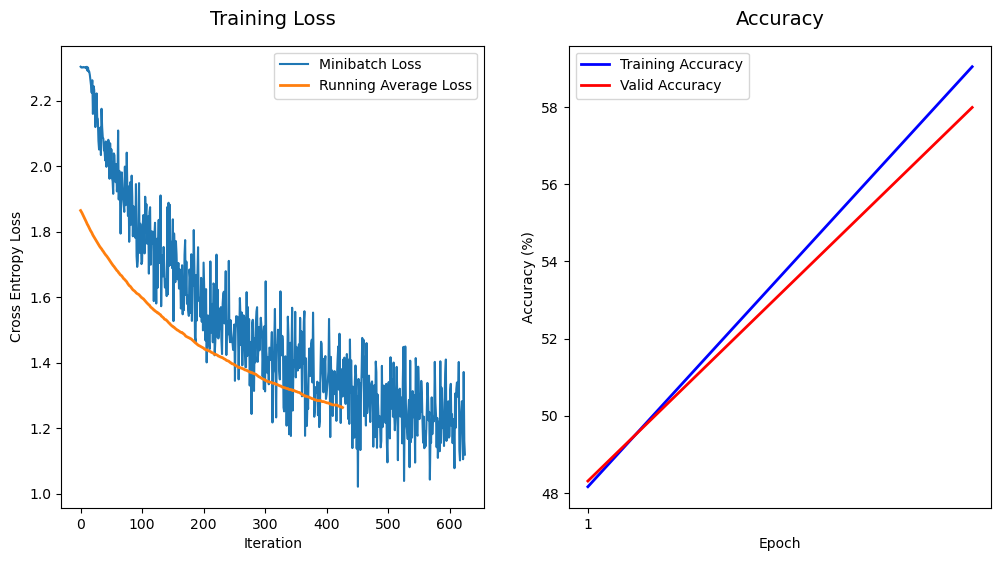

In [55]:
def plot_training_metrics(log_dict: dict):
    loss_list = log_dict["train_loss_per_batch"]
    train_acc = log_dict["train_acc_per_epoch"]
    valid_acc = log_dict["valid_acc_per_epoch"]
    running_avg_loss = np.convolve(loss_list, np.ones(200) / 200, mode="valid")

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot training loss
    axs[0].plot(loss_list, label="Minibatch Loss")
    axs[0].plot(running_avg_loss, label="Running Average Loss", linewidth=2)
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Cross Entropy Loss")
    axs[0].set_title("Training Loss", fontsize=14, pad=15)
    axs[0].legend(loc="best")

    # plot training accuracy
    axs[1].plot(
        np.arange(1, num_epochs + 1),
        train_acc,
        label="Training Accuracy",
        color="blue",
        markersize=6,
        linewidth=2,
    )
    axs[1].plot(
        np.arange(1, num_epochs + 1),
        valid_acc,
        label="Valid Accuracy",
        color="red",
        markersize=6,
        linewidth=2,
    )
    axs[1].set_xticks(np.arange(1, num_epochs + 1, 2))
    axs[1].xlim = (0, num_epochs + 1)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].set_title("Accuracy", fontsize=14, pad=15)
    axs[1].legend(loc="best")
    # axs[1].grid(True)

    fig.savefig("training_performance.svg", format="svg")
    fig.show()


plot_training_metrics(log_dict)

In [58]:
with torch.set_grad_enabled(False):
    test_eval_res = eval_model(model, test_loader)
    test_loss = test_eval_res["avg_loss"]
    test_acc = test_eval_res["accuracy"]
    class_correct = test_eval_res["class_correct"]
    class_total = test_eval_res["class_total"]

print(f"Test Loss: {test_loss:.4f}\n")
for i in range(num_classes):
    print(
        "Test Accuracy of %8s: %2d%% (%2d/%2d)"
        % (
            classes[i],
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i]),
        )
    )
print(f"\nTest Accuracy (Overall): {test_acc:.2f}%")

Test Loss: 1.1704

Test Accuracy of Airplane: 71% (715/1000)
Test Accuracy of      Car: 71% (713/1000)
Test Accuracy of     Bird: 47% (471/1000)
Test Accuracy of      Cat: 45% (452/1000)
Test Accuracy of     Deer: 38% (389/1000)
Test Accuracy of      Dog: 45% (452/1000)
Test Accuracy of     Frog: 61% (616/1000)
Test Accuracy of    Horse: 62% (625/1000)
Test Accuracy of     Ship: 74% (740/1000)
Test Accuracy of    Truck: 63% (636/1000)

Test Accuracy (Overall): 58.09%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

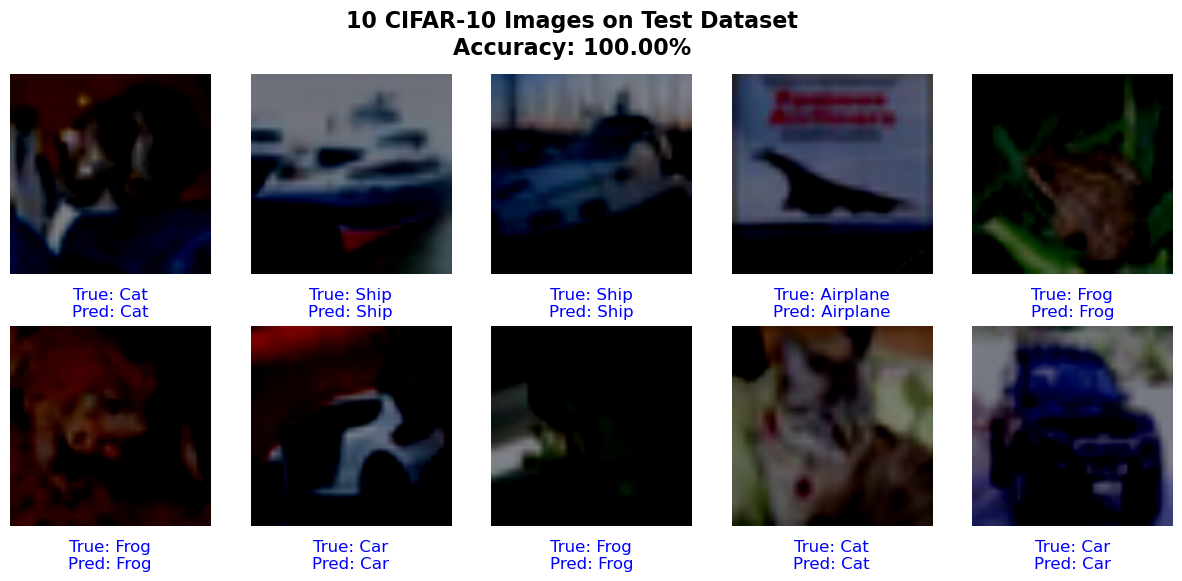

In [57]:
def plot_random_images_with_predictions(model, data_loader, classes):
    # step1: get 10 sample images from the data loader
    images, labels = next(iter(data_loader))
    images, labels = images[:10], labels[:10]

    images = images.to(device)
    labels = labels.to(device)

    # step2: get model predictions and calculate accuracy
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    correct_count = (predicted == labels).sum().item()
    accuracy = correct_count / len(labels) * 100

    # step3: plot the images with the predicted labels
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(
        f"10 CIFAR-10 Images on Test Dataset\nAccuracy: {accuracy:.2f}%",
        fontsize=16,
        fontweight=600,
    )

    for i in range(10):
        ax = axes[i // 5, i % 5]
        img = np.transpose(images[i].numpy(), (1, 2, 0))

        ax.imshow(img)
        ax.axis("off")

        color = "blue" if predicted[i] == labels[i] else "red"
        ax.set_title(
            f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}",
            fontsize=12,
            color=color,
            y=-0.25,
        )

    plt.savefig("cifar10_predictions.svg", format="svg")
    plt.show()


plot_random_images_with_predictions(model, test_loader, classes)

运行过程输出：
```
Fri May 31 17:30:37 2024       
Using device: cuda:0
Files already downloaded and verified
Training Set:
image size per batch torch.Size([128, 3, 224, 224])
label size per batch torch.Size([128])
Testing Set:
image size per batch torch.Size([128, 3, 224, 224])
label size per batch torch.Size([128])
Epoch: 001/025 | Batch 0000/0313 | Loss: 2.3017
Epoch: 001/025 | Batch 0050/0313 | Loss: 2.0209
Epoch: 001/025 | Batch 0100/0313 | Loss: 1.7412
Epoch: 001/025 | Batch 0150/0313 | Loss: 1.4886
Epoch: 001/025 | Batch 0200/0313 | Loss: 1.6830
Epoch: 001/025 | Batch 0250/0313 | Loss: 1.4265
Epoch: 001/025 | Batch 0300/0313 | Loss: 1.3529
#Epoch: 001/025 | Train. Acc.: 51.138% | Loss: 1.330
#Epoch: 001/025 | Valid. Acc.: 50.280% | Loss: 1.345
#Validation loss decreased (inf --> 1.344877). Saving model ...
Time elapsed: 1.43 min
Epoch: 002/025 | Batch 0000/0313 | Loss: 1.3427
Epoch: 002/025 | Batch 0050/0313 | Loss: 1.1624
Epoch: 002/025 | Batch 0100/0313 | Loss: 1.3063
Epoch: 002/025 | Batch 0150/0313 | Loss: 1.3578
Epoch: 002/025 | Batch 0200/0313 | Loss: 1.2141
Epoch: 002/025 | Batch 0250/0313 | Loss: 1.1788
Epoch: 002/025 | Batch 0300/0313 | Loss: 1.3348
#Epoch: 002/025 | Train. Acc.: 59.340% | Loss: 1.137
#Epoch: 002/025 | Valid. Acc.: 57.450% | Loss: 1.175
#Validation loss decreased (1.344877 --> 1.175130). Saving model ...
Time elapsed: 2.71 min
Epoch: 003/025 | Batch 0000/0313 | Loss: 1.1454
Epoch: 003/025 | Batch 0050/0313 | Loss: 1.2068
Epoch: 003/025 | Batch 0100/0313 | Loss: 0.9958
Epoch: 003/025 | Batch 0150/0313 | Loss: 0.9236
Epoch: 003/025 | Batch 0200/0313 | Loss: 1.0775
Epoch: 003/025 | Batch 0250/0313 | Loss: 1.0687
Epoch: 003/025 | Batch 0300/0313 | Loss: 1.0100
#Epoch: 003/025 | Train. Acc.: 66.250% | Loss: 0.947
#Epoch: 003/025 | Valid. Acc.: 63.890% | Loss: 1.003
#Validation loss decreased (1.175130 --> 1.002873). Saving model ...
Time elapsed: 3.99 min
Epoch: 004/025 | Batch 0000/0313 | Loss: 0.9727
Epoch: 004/025 | Batch 0050/0313 | Loss: 1.0347
Epoch: 004/025 | Batch 0100/0313 | Loss: 0.9484
Epoch: 004/025 | Batch 0150/0313 | Loss: 1.0707
Epoch: 004/025 | Batch 0200/0313 | Loss: 0.9105
Epoch: 004/025 | Batch 0250/0313 | Loss: 0.7953
Epoch: 004/025 | Batch 0300/0313 | Loss: 0.7373
#Epoch: 004/025 | Train. Acc.: 70.993% | Loss: 0.827
#Epoch: 004/025 | Valid. Acc.: 68.020% | Loss: 0.902
#Validation loss decreased (1.002873 --> 0.901523). Saving model ...
Time elapsed: 5.27 min
Epoch: 005/025 | Batch 0000/0313 | Loss: 0.8581
Epoch: 005/025 | Batch 0050/0313 | Loss: 0.8079
Epoch: 005/025 | Batch 0100/0313 | Loss: 0.7623
Epoch: 005/025 | Batch 0150/0313 | Loss: 0.7906
Epoch: 005/025 | Batch 0200/0313 | Loss: 0.7247
Epoch: 005/025 | Batch 0250/0313 | Loss: 0.7969
Epoch: 005/025 | Batch 0300/0313 | Loss: 0.7877
#Epoch: 005/025 | Train. Acc.: 75.078% | Loss: 0.711
#Epoch: 005/025 | Valid. Acc.: 71.060% | Loss: 0.812
#Validation loss decreased (0.901523 --> 0.812410). Saving model ...
Time elapsed: 6.54 min
Epoch: 006/025 | Batch 0000/0313 | Loss: 0.8930
Epoch: 006/025 | Batch 0050/0313 | Loss: 0.8136
Epoch: 006/025 | Batch 0100/0313 | Loss: 0.7832
Epoch: 006/025 | Batch 0150/0313 | Loss: 0.8659
Epoch: 006/025 | Batch 0200/0313 | Loss: 0.6879
Epoch: 006/025 | Batch 0250/0313 | Loss: 0.7588
Epoch: 006/025 | Batch 0300/0313 | Loss: 0.7617
#Epoch: 006/025 | Train. Acc.: 78.088% | Loss: 0.633
#Epoch: 006/025 | Valid. Acc.: 73.800% | Loss: 0.762
#Validation loss decreased (0.812410 --> 0.761980). Saving model ...
Time elapsed: 7.82 min
Epoch: 007/025 | Batch 0000/0313 | Loss: 0.7081
Epoch: 007/025 | Batch 0050/0313 | Loss: 0.6752
Epoch: 007/025 | Batch 0100/0313 | Loss: 0.7105
Epoch: 007/025 | Batch 0150/0313 | Loss: 0.7229
Epoch: 007/025 | Batch 0200/0313 | Loss: 0.5458
Epoch: 007/025 | Batch 0250/0313 | Loss: 0.6191
Epoch: 007/025 | Batch 0300/0313 | Loss: 0.7488
#Epoch: 007/025 | Train. Acc.: 82.013% | Loss: 0.538
#Epoch: 007/025 | Valid. Acc.: 75.900% | Loss: 0.696
#Validation loss decreased (0.761980 --> 0.695666). Saving model ...
Time elapsed: 9.09 min
Epoch: 008/025 | Batch 0000/0313 | Loss: 0.6744
Epoch: 008/025 | Batch 0050/0313 | Loss: 0.7209
Epoch: 008/025 | Batch 0100/0313 | Loss: 0.6444
Epoch: 008/025 | Batch 0150/0313 | Loss: 0.7661
Epoch: 008/025 | Batch 0200/0313 | Loss: 0.8161
Epoch: 008/025 | Batch 0250/0313 | Loss: 0.5681
Epoch: 008/025 | Batch 0300/0313 | Loss: 0.7032
#Epoch: 008/025 | Train. Acc.: 82.980% | Loss: 0.493
#Epoch: 008/025 | Valid. Acc.: 75.930% | Loss: 0.700
Time elapsed: 10.36 min
Epoch: 009/025 | Batch 0000/0313 | Loss: 0.4944
Epoch: 009/025 | Batch 0050/0313 | Loss: 0.5440
Epoch: 009/025 | Batch 0100/0313 | Loss: 0.6446
Epoch: 009/025 | Batch 0150/0313 | Loss: 0.6395
Epoch: 009/025 | Batch 0200/0313 | Loss: 0.4281
Epoch: 009/025 | Batch 0250/0313 | Loss: 0.5918
Epoch: 009/025 | Batch 0300/0313 | Loss: 0.6320
#Epoch: 009/025 | Train. Acc.: 86.615% | Loss: 0.397
#Epoch: 009/025 | Valid. Acc.: 77.550% | Loss: 0.649
#Validation loss decreased (0.695666 --> 0.648682). Saving model ...
Time elapsed: 11.64 min
Epoch: 010/025 | Batch 0000/0313 | Loss: 0.4882
Epoch: 010/025 | Batch 0050/0313 | Loss: 0.4429
Epoch: 010/025 | Batch 0100/0313 | Loss: 0.3756
Epoch: 010/025 | Batch 0150/0313 | Loss: 0.4554
Epoch: 010/025 | Batch 0200/0313 | Loss: 0.5100
Epoch: 010/025 | Batch 0250/0313 | Loss: 0.4700
Epoch: 010/025 | Batch 0300/0313 | Loss: 0.6486
#Epoch: 010/025 | Train. Acc.: 88.060% | Loss: 0.362
#Epoch: 010/025 | Valid. Acc.: 77.330% | Loss: 0.646
#Validation loss decreased (0.648682 --> 0.646485). Saving model ...
Time elapsed: 12.91 min
Epoch: 011/025 | Batch 0000/0313 | Loss: 0.4510
Epoch: 011/025 | Batch 0050/0313 | Loss: 0.4270
Epoch: 011/025 | Batch 0100/0313 | Loss: 0.5027
Epoch: 011/025 | Batch 0150/0313 | Loss: 0.4213
Epoch: 011/025 | Batch 0200/0313 | Loss: 0.4770
Epoch: 011/025 | Batch 0250/0313 | Loss: 0.4823
Epoch: 011/025 | Batch 0300/0313 | Loss: 0.3968
#Epoch: 011/025 | Train. Acc.: 89.110% | Loss: 0.317
#Epoch: 011/025 | Valid. Acc.: 77.500% | Loss: 0.666
Time elapsed: 14.18 min
Epoch: 012/025 | Batch 0000/0313 | Loss: 0.4277
Epoch: 012/025 | Batch 0050/0313 | Loss: 0.3068
Epoch: 012/025 | Batch 0100/0313 | Loss: 0.4946
Epoch: 012/025 | Batch 0150/0313 | Loss: 0.4692
Epoch: 012/025 | Batch 0200/0313 | Loss: 0.4198
Epoch: 012/025 | Batch 0250/0313 | Loss: 0.2767
Epoch: 012/025 | Batch 0300/0313 | Loss: 0.4829
#Epoch: 012/025 | Train. Acc.: 93.137% | Loss: 0.233
#Epoch: 012/025 | Valid. Acc.: 79.320% | Loss: 0.603
#Validation loss decreased (0.646485 --> 0.603430). Saving model ...
Time elapsed: 15.46 min
Epoch: 013/025 | Batch 0000/0313 | Loss: 0.2529
Epoch: 013/025 | Batch 0050/0313 | Loss: 0.2869
Epoch: 013/025 | Batch 0100/0313 | Loss: 0.2581
Epoch: 013/025 | Batch 0150/0313 | Loss: 0.3630
Epoch: 013/025 | Batch 0200/0313 | Loss: 0.2749
Epoch: 013/025 | Batch 0250/0313 | Loss: 0.4173
Epoch: 013/025 | Batch 0300/0313 | Loss: 0.3402
#Epoch: 013/025 | Train. Acc.: 95.502% | Loss: 0.158
#Epoch: 013/025 | Valid. Acc.: 80.070% | Loss: 0.607
Time elapsed: 16.73 min
Epoch: 014/025 | Batch 0000/0313 | Loss: 0.3184
Epoch: 014/025 | Batch 0050/0313 | Loss: 0.1766
Epoch: 014/025 | Batch 0100/0313 | Loss: 0.4042
Epoch: 014/025 | Batch 0150/0313 | Loss: 0.2446
Epoch: 014/025 | Batch 0200/0313 | Loss: 0.1919
Epoch: 014/025 | Batch 0250/0313 | Loss: 0.2405
Epoch: 014/025 | Batch 0300/0313 | Loss: 0.2816
#Epoch: 014/025 | Train. Acc.: 96.730% | Loss: 0.140
#Epoch: 014/025 | Valid. Acc.: 80.650% | Loss: 0.594
#Validation loss decreased (0.603430 --> 0.593804). Saving model ...
Time elapsed: 18.10 min
Epoch: 015/025 | Batch 0000/0313 | Loss: 0.2748
Epoch: 015/025 | Batch 0050/0313 | Loss: 0.1685
Epoch: 015/025 | Batch 0100/0313 | Loss: 0.3303
Epoch: 015/025 | Batch 0150/0313 | Loss: 0.2216
Epoch: 015/025 | Batch 0200/0313 | Loss: 0.1645
Epoch: 015/025 | Batch 0250/0313 | Loss: 0.1727
Epoch: 015/025 | Batch 0300/0313 | Loss: 0.3693
#Epoch: 015/025 | Train. Acc.: 97.703% | Loss: 0.095
#Epoch: 015/025 | Valid. Acc.: 80.690% | Loss: 0.634
Time elapsed: 19.39 min
Epoch: 016/025 | Batch 0000/0313 | Loss: 0.2093
Epoch: 016/025 | Batch 0050/0313 | Loss: 0.1749
Epoch: 016/025 | Batch 0100/0313 | Loss: 0.2377
Epoch: 016/025 | Batch 0150/0313 | Loss: 0.1503
Epoch: 016/025 | Batch 0200/0313 | Loss: 0.1211
Epoch: 016/025 | Batch 0250/0313 | Loss: 0.2467
Epoch: 016/025 | Batch 0300/0313 | Loss: 0.2200
#Epoch: 016/025 | Train. Acc.: 98.070% | Loss: 0.079
#Epoch: 016/025 | Valid. Acc.: 80.900% | Loss: 0.652
Time elapsed: 20.64 min
Epoch: 017/025 | Batch 0000/0313 | Loss: 0.1996
Epoch: 017/025 | Batch 0050/0313 | Loss: 0.1311
Epoch: 017/025 | Batch 0100/0313 | Loss: 0.1191
Epoch: 017/025 | Batch 0150/0313 | Loss: 0.2163
Epoch: 017/025 | Batch 0200/0313 | Loss: 0.1825
Epoch: 017/025 | Batch 0250/0313 | Loss: 0.1524
Epoch: 017/025 | Batch 0300/0313 | Loss: 0.2047
#Epoch: 017/025 | Train. Acc.: 99.272% | Loss: 0.047
#Epoch: 017/025 | Valid. Acc.: 81.710% | Loss: 0.627
Time elapsed: 21.89 min
Epoch: 018/025 | Batch 0000/0313 | Loss: 0.0968
Epoch: 018/025 | Batch 0050/0313 | Loss: 0.1828
Epoch: 018/025 | Batch 0100/0313 | Loss: 0.1312
Epoch: 018/025 | Batch 0150/0313 | Loss: 0.1753
Epoch: 018/025 | Batch 0200/0313 | Loss: 0.2779
Epoch: 018/025 | Batch 0250/0313 | Loss: 0.1252
Epoch: 018/025 | Batch 0300/0313 | Loss: 0.1408
#Epoch: 018/025 | Train. Acc.: 99.472% | Loss: 0.036
#Epoch: 018/025 | Valid. Acc.: 80.980% | Loss: 0.665
Time elapsed: 23.15 min
Epoch: 019/025 | Batch 0000/0313 | Loss: 0.0982
Epoch: 019/025 | Batch 0050/0313 | Loss: 0.0837
Epoch: 019/025 | Batch 0100/0313 | Loss: 0.0618
Epoch: 019/025 | Batch 0150/0313 | Loss: 0.1355
Epoch: 019/025 | Batch 0200/0313 | Loss: 0.1114
Epoch: 019/025 | Batch 0250/0313 | Loss: 0.1032
Epoch: 019/025 | Batch 0300/0313 | Loss: 0.1260
#Epoch: 019/025 | Train. Acc.: 99.407% | Loss: 0.029
#Epoch: 019/025 | Valid. Acc.: 81.060% | Loss: 0.712
Time elapsed: 24.40 min
Epoch: 020/025 | Batch 0000/0313 | Loss: 0.0996
Epoch: 020/025 | Batch 0050/0313 | Loss: 0.1161
Epoch: 020/025 | Batch 0100/0313 | Loss: 0.1309
Epoch: 020/025 | Batch 0150/0313 | Loss: 0.1862
Epoch: 020/025 | Batch 0200/0313 | Loss: 0.1636
Epoch: 020/025 | Batch 0250/0313 | Loss: 0.1311
Epoch: 020/025 | Batch 0300/0313 | Loss: 0.1208
#Epoch: 020/025 | Train. Acc.: 99.505% | Loss: 0.033
#Epoch: 020/025 | Valid. Acc.: 80.760% | Loss: 0.678
Time elapsed: 25.65 min
Epoch: 021/025 | Batch 0000/0313 | Loss: 0.1077
Epoch: 021/025 | Batch 0050/0313 | Loss: 0.1287
Epoch: 021/025 | Batch 0100/0313 | Loss: 0.0838
Epoch: 021/025 | Batch 0150/0313 | Loss: 0.1266
Epoch: 021/025 | Batch 0200/0313 | Loss: 0.1040
Epoch: 021/025 | Batch 0250/0313 | Loss: 0.2142
Epoch: 021/025 | Batch 0300/0313 | Loss: 0.0782
#Epoch: 021/025 | Train. Acc.: 99.460% | Loss: 0.029
#Epoch: 021/025 | Valid. Acc.: 81.020% | Loss: 0.735
Time elapsed: 26.91 min
Epoch: 022/025 | Batch 0000/0313 | Loss: 0.1289
Epoch: 022/025 | Batch 0050/0313 | Loss: 0.1156
Epoch: 022/025 | Batch 0100/0313 | Loss: 0.0876
Epoch: 022/025 | Batch 0150/0313 | Loss: 0.0662
Epoch: 022/025 | Batch 0200/0313 | Loss: 0.1825
Epoch: 022/025 | Batch 0250/0313 | Loss: 0.0987
Epoch: 022/025 | Batch 0300/0313 | Loss: 0.1517
#Epoch: 022/025 | Train. Acc.: 99.760% | Loss: 0.019
#Epoch: 022/025 | Valid. Acc.: 81.780% | Loss: 0.694
Time elapsed: 28.17 min
Epoch: 023/025 | Batch 0000/0313 | Loss: 0.0591
Epoch: 023/025 | Batch 0050/0313 | Loss: 0.1310
Epoch: 023/025 | Batch 0100/0313 | Loss: 0.1130
Epoch: 023/025 | Batch 0150/0313 | Loss: 0.0936
Epoch: 023/025 | Batch 0200/0313 | Loss: 0.0985
Epoch: 023/025 | Batch 0250/0313 | Loss: 0.1245
Epoch: 023/025 | Batch 0300/0313 | Loss: 0.0679
#Epoch: 023/025 | Train. Acc.: 99.838% | Loss: 0.015
#Epoch: 023/025 | Valid. Acc.: 81.610% | Loss: 0.703
Time elapsed: 29.46 min
Epoch: 024/025 | Batch 0000/0313 | Loss: 0.0391
Epoch: 024/025 | Batch 0050/0313 | Loss: 0.1176
Epoch: 024/025 | Batch 0100/0313 | Loss: 0.0350
Epoch: 024/025 | Batch 0150/0313 | Loss: 0.0562
Epoch: 024/025 | Batch 0200/0313 | Loss: 0.0510
Epoch: 024/025 | Batch 0250/0313 | Loss: 0.1045
Epoch: 024/025 | Batch 0300/0313 | Loss: 0.1263
#Epoch: 024/025 | Train. Acc.: 99.795% | Loss: 0.013
#Epoch: 024/025 | Valid. Acc.: 81.960% | Loss: 0.732
Time elapsed: 30.74 min
Epoch: 025/025 | Batch 0000/0313 | Loss: 0.0776
Epoch: 025/025 | Batch 0050/0313 | Loss: 0.0786
Epoch: 025/025 | Batch 0100/0313 | Loss: 0.0959
Epoch: 025/025 | Batch 0150/0313 | Loss: 0.0654
Epoch: 025/025 | Batch 0200/0313 | Loss: 0.0966
Epoch: 025/025 | Batch 0250/0313 | Loss: 0.0617
Epoch: 025/025 | Batch 0300/0313 | Loss: 0.1552
#Epoch: 025/025 | Train. Acc.: 99.913% | Loss: 0.010
#Epoch: 025/025 | Valid. Acc.: 81.740% | Loss: 0.733
Time elapsed: 32.00 min
Total Training Time: 32.00 min
Test Loss: 0.6170

Test Accuracy of Airplane: 82% (826/1000)
Test Accuracy of      Car: 90% (907/1000)
Test Accuracy of     Bird: 73% (734/1000)
Test Accuracy of      Cat: 54% (543/1000)
Test Accuracy of     Deer: 72% (727/1000)
Test Accuracy of      Dog: 73% (734/1000)
Test Accuracy of     Frog: 87% (874/1000)
Test Accuracy of    Horse: 86% (868/1000)
Test Accuracy of     Ship: 88% (881/1000)
Test Accuracy of    Truck: 88% (882/1000)

Test Accuracy (Overall): 79.76%
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
```
